In [1]:
# General imports

import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as metrics
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
# Custom Imports

COLAB = 'google.colab' in sys.modules
LOCAL = not COLAB

if COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/
    %cd ./visiope/
    !git checkout tests
    !git branch
    %cd ../

    # Get the root directory of the Git project
    root_dir = '/content/visiope'

    # Add custom modules to path
    custom_modules_path = root_dir + '/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsSplitter, Ai4MarsDataLoader

# Import Loss
from loss.loss import Ai4MarsCrossEntropy, Ai4MarsDiceLoss

# Import Trainer
from trainer.trainer import Ai4MarsTrainer

# Import Tester
from tester.tester import Ai4MarsTester

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Dataloader

# Set this to True if you wnat to load directly the dataloader
# this can be done only on colab and it is useful to avoid runtime crash
LOAD = False

if LOAD:

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/104YvO3LcU76euuVe-_62eS_Rld-tOZeh?usp=drive_link'

            !gdown --folder {url} -O /content/

            load_path = '/content/dataset/dataset.pt'

    elif LOCAL: load_path = root_dir + '/datasetup/dataset/dataset.pt'

    dataset = torch.load(load_path)
    train_set = dataset[0]
    test_set = dataset[1]
    val_set = dataset[2]

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader(
        [train_set, test_set, val_set], [32, 16, 16])


else:

    # Insert here your local path to the dataset (temporary)
    data_path ='/home/leeoos/Desktop/' #input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = 100 #int(input("Number of images (max 1000): "))

    save_path = None
    # Uncomment the following line to the dataset on a local path
    #save_path = root_dir + '/datasetup/dataset/'

    if num_images > 1000 : raise Exception("Trying to import too many images")

    # Import data as Ai4MarsDataset
    importer = Ai4MarsDownload()
    X, y = importer(PATH=data_path, NUM_IMAGES=num_images)

    transform = None
    # Uncomment the following lines to apply transformations to the dataset
    '''
    transform = transforms.RandomChoice([
     transforms.RandomRotation(90)])
    '''
    
    
    # Split the dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1], transform=transform,
                                            SAVE_PATH=save_path, SIZE=128)

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader([train_set, test_set, val_set], [32, 16, 16],
                                                   SIZE=128, SAVE_PATH=save_path)

This are the Class parameters: 
               Dataset: ai4mars-dataset-merged-0.1 
               Path to the dataset: /home/leeoos/Desktop/ 
               Colab Environment: False 
               Number of images to load: 100 
               Saving path for X and y: None
You already have ai4mars-dataset-merged-0.1
Unpacking images and lables from: ai4mars-dataset-merged-0.1 ...
Inputs len: 100
Labels len: 100
Converting inputs and labels into torch tensors ...
Done

Begin processing: 
             Dataset: ai4mars-dataset-merged-0.1 
             Colab environment: False 
             Split percentages: [0.7, 0.2, 0.1] 
             Transformation: None
Splitting in progress ...
Resizing the ai4mars-dataset-merged-0.1 images at size: 128 ...
Done 

Building Dataloaders
Done 



70
20
10
image shape: torch.Size([128, 128, 3])


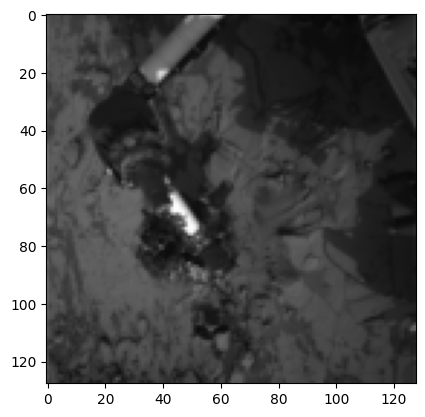

image shape: torch.Size([128, 128, 1])


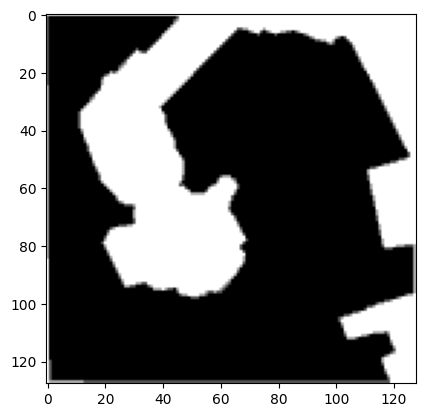

image shape: torch.Size([128, 128, 3])


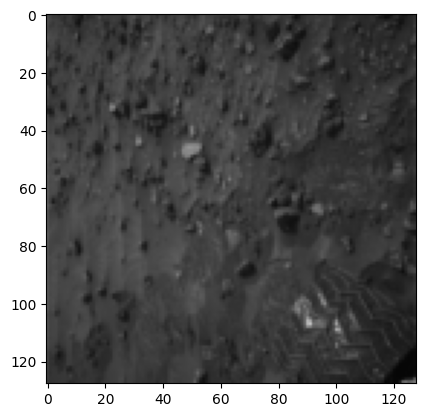

image shape: torch.Size([128, 128, 1])


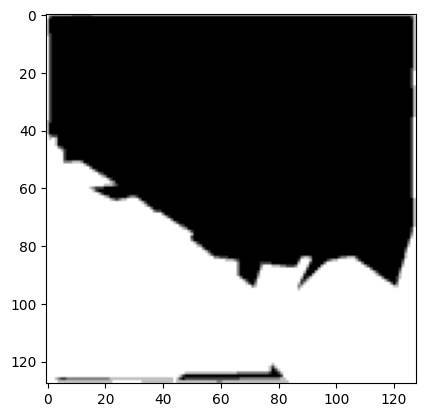

In [4]:
import matplotlib.pyplot as plt

print(len(train_set))
print(len(test_set))
print(len(val_set))

image, label = train_set.__getitem__(0)

print(f'image shape: {image.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

k = 0 
for image, label in train_loader:
    if k == 1: break
    k += 1

print(f'image shape: {image[0].permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label[0].permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()


In [5]:
# Clone remote repo with existing models

if COLAB:
    !git clone https://github.com/sithu31296/semantic-segmentation
    %cd semantic-segmentation
    %pip install -e .
    %pip install -U gdown

In [6]:
#  Import segformer

from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B1',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth',
                                     map_location=device))
    print("Pretrained model's weights downloaded")
except:
    print("Download a pretrained model's weights from the result table.")

model.to(device)

print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [7]:
# Training parameters

loss_fn = Ai4MarsDiceLoss().to(device)
#loss_fn = Ai4MarsCrossEntropy().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
transform = transforms.RandomChoice([
     transforms.RandomRotation(90)])

trainer = Ai4MarsTrainer(loss_fn, optimizer, train_loader, val_loader, 
                         transform=transform, device=device, model_name='MiT-B1', dump=False)

Data will be saved in /home/leeoos/Projects/master/airo-visiope/visiope/experiments/data/20230716_005805MiT-B1/hist/


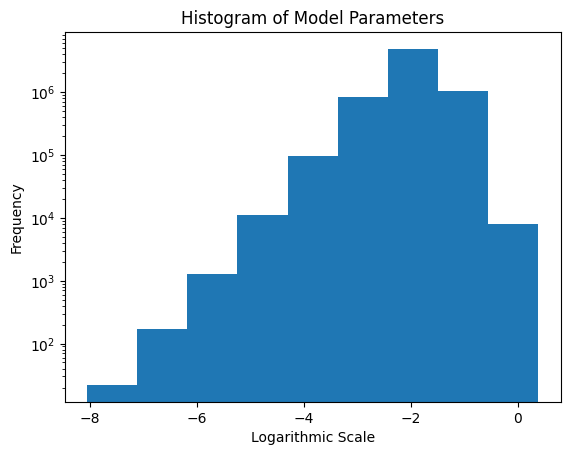

In [8]:
# Module Parameters
trainer.param_hist(model, SAVE_PATH=root_dir+'/experiments', label='before')

In [9]:
# Start training
trainer.train_multiple_epoch(model, EPOCHS=5, SAVE_PATH=root_dir+'/experiments')

EPOCH 1
Train loss: 0.7595705986022949
Transformed train loss: 0.1827296018600464
Time needed for training: 4.142389297485352 seconds
Validation loss: 0.7613213658332825 

EPOCH 2
Train loss: 0.6230311791102091
Transformed train loss: 0.15867003798484802
Time needed for training: 4.047786712646484 seconds
Validation loss: 0.6865526437759399 

EPOCH 3
Train loss: 0.6280438303947449
Transformed train loss: 0.14324072003364563
Time needed for training: 3.997837543487549 seconds
Validation loss: 0.6562322974205017 

EPOCH 4
Train loss: 0.6035376191139221
Transformed train loss: 0.1303914487361908
Time needed for training: 3.862671136856079 seconds
Validation loss: 0.679965078830719 

EPOCH 5
Train loss: 0.6163188219070435
Transformed train loss: 0.12861236929893494
Time needed for training: 3.8996639251708984 seconds
Validation loss: 0.6689043641090393 



Data will be saved in /home/leeoos/Projects/master/airo-visiope/visiope/experiments/data/20230716_005805MiT-B1/loss/


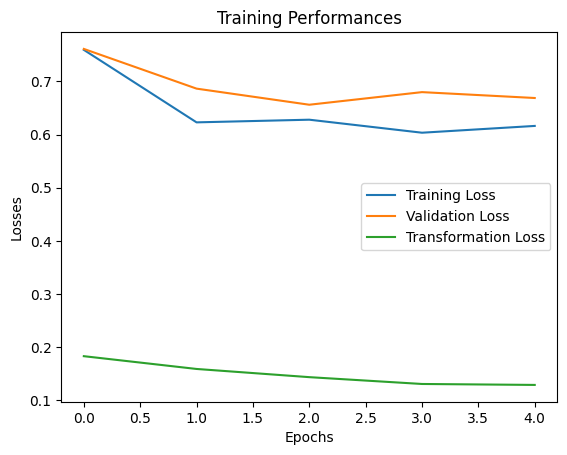

Train mean loss: 0.6461004098256429
Validation mean loss: 0.6905951499938965


In [10]:
# Plot loss

import matplotlib.pyplot as plt

trainer.plot_loss(model=model, SAVE_PATH=root_dir+'/experiments')

In [11]:
print(len(train_loader))
print(len(train_loader.dataset))
print(train_loader.batch_size)
import math
print(math.ceil(len(train_loader.dataset) / train_loader.batch_size))

3
70
32
3


In [12]:
# Testing and evaluation Metrics

metric = metrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
tester = Ai4MarsTester(loss_fn, metric, test_loader, device=device)

In [13]:
# Start testing

tester.test_one_epoch(model)

Test loss: 0.6895509362220764

Metrics MulticlassJaccardIndex(): 0.42390984296798706


Data will be saved in /home/leeoos/Projects/master/airo-visiope/visiope/experiments/data/20230716_005805MiT-B1/hist/


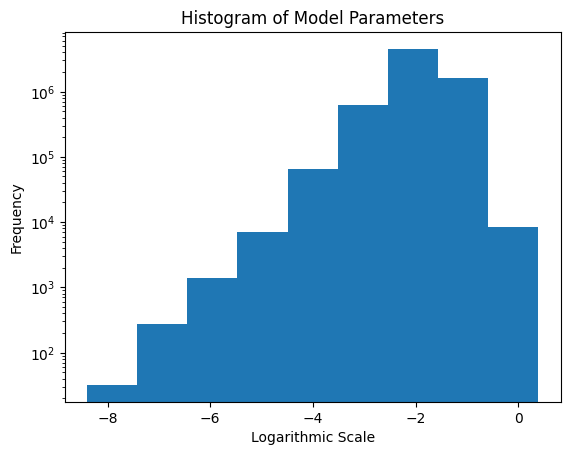

In [14]:
# Module Parameters
trainer.param_hist(model, SAVE_PATH=root_dir+'/experiments', label='after')